# 03_dislo_analysis: Finding Atoms in the Dislocation Core

The purpose of this Jupyter Notebook is to isolate atoms in the dislocation core. The data used to do this is extracted from the previous step (02_minimize_dislo).

The general workflow of this notebook involves the following:
- Step 1: Import libraries and set input data paths.
- Step 2: Extract the necessary dump data from the dump files produced by LAMMPS simulation.
- Step 3: Filter the necessary data to find atoms in the dislocation core. 
- Step 4: Save the ID's (Particle Identifiers) of the atoms in the dislocation core for future simulations.

The end result of this Jupyter Notebook will be a textfile containing a list of particle ID's, that tell you which atoms are in the dislocation core. Moreover, the order of the ID's is given in the atoms distance from the center of the simulation box along the Z-axis. (I really hope that makes sense).

## Step 1: Import Libraries and Set Input Data Paths

This is the easy part (hopefully). It is recommended that you run this Jupyter Notebook with the 'Analysis' Conda Environment which can be found and exported from '000_conda_envs' in the root directory of this repository.

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

input_dir = '../02_minimize_dislo/min_dump'
input_file = 'straight_edge_dislo_dump'

dislo_dump_path = os.path.join(input_dir, input_file)

## Step 2: Extracing dump data

Now that we have the input paths to the dump files and have imported libraries, we can start extracting the data. The cell below contains two functions:
1) extract_box_data()

This function looks at the dump file produced by LAMMPS and extracts the dimensions of the simulation box. This information will be important for later things, such as plotting graphs and filtering data based on position. This function returns a dictionary containing the minimium and maximum coodinates on the x, y and z planes.

2) extract_atom_data()

This function looks at the dump file and extracts the atom information. This includes the x, y, and z position of each individual item. It will also collect the particle ID's and the potential energy of each atom (c_peratom).

In [76]:
def extract_box_data(input_path):
    """
    Extracts the simulation box boundaries from a LAMMPS dump file.

    Parameters:
    -----------
    input_path : str
        Path to the LAMMPS dump file.

    Returns:
    --------
    dict
        Dictionary with keys 'xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi' representing
        the lower and upper bounds of the simulation box in each dimension.

    Notes:
    ------
    This function looks for the line containing "ITEM: BOX BOUNDS" and
    reads the next three lines for the x, y, and z bounds respectively.
    """
    box_bounds = {}
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: BOX BOUNDS" in line:
                x_bounds = list(map(float, lines[i+1].split()))
                y_bounds = list(map(float, lines[i+2].split()))
                z_bounds = list(map(float, lines[i+3].split()))
                box_bounds = {
                    'xlo': x_bounds[0], 'xhi': x_bounds[1],
                    'ylo': y_bounds[0], 'yhi': y_bounds[1],
                    'zlo': z_bounds[0], 'zhi': z_bounds[1],
                }
                break
    return box_bounds

def extract_atom_data(input_path):
    """
    Extracts atom data from a LAMMPS dump file into a pandas DataFrame.

    Parameters:
    -----------
    input_path : str
        Path to the LAMMPS dump file.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the atom data with columns corresponding to the
        headers listed after "ITEM: ATOMS" in the dump file.

    Notes:
    ------
    This function searches for the line containing "ITEM: ATOMS", reads
    the column headers from that line, and then reads all following lines
    as numerical atom data.
    """
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: ATOMS" in line:
                # Extract column headers from the line, ignoring the first two words
                headers = line.strip().split()[2:]
                data_start = i + 1
                break
    # Read atom data lines
    data_lines = lines[data_start:]
    # Convert each line to a list of floats
    data = [list(map(float, l.strip().split())) for l in data_lines]
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    return df

box = extract_box_data(dislo_dump_path)
atom_df = extract_atom_data(dislo_dump_path)

print("Box Dimensions:", box)
print("\nFirst few atoms:\n", atom_df.head())
print(f"\nNumber of atoms: {len(atom_df)}")

Box Dimensions: {'xlo': 0.0, 'xhi': 202.76507103393442, 'ylo': 0.0, 'yhi': 201.8987649155792, 'zlo': 0.0, 'zhi': 69.93978376383757}

First few atoms:
         id        x         y         z  c_peratom    c_csym  c_stress[1]  \
0  14951.0  66.9514   6.91273  0.980550   -2.88044  20.77780     457383.0   
1  13861.0  57.0250  10.92320  0.942169   -2.87617  21.14360     651233.0   
2  14129.0  57.8804  10.88700  3.330230   -3.08425  16.05880     367492.0   
3  14131.0  59.5444  10.85790  1.139810   -3.47319   5.84228     446893.0   
4  14401.0  60.4037  10.81380  3.517850   -3.65471   9.75565     706932.0   

   c_stress[2]  c_stress[3]  c_stress[4]  c_stress[5]  c_stress[6]  
0    -17323.30     151102.0     -8361.66     165516.0     383711.0  
1     -3246.59     143009.0    -79499.70     166164.0     375637.0  
2    -49297.30     154712.0     -8624.03     114826.0     333494.0  
3    112587.00     311608.0   -106040.00    -393366.0      75341.8  
4    498538.00     406178.0   -299817.00 

We can now plot the 3D atomistic data as a 3D scatter plot. To do this, we have the plot_atomistic_data_3d() function. This function takes the atom dataframe, the box dictionary and plots a 3D scatter graph of the atomistic data colour-coded to each atom's potential energy. Below I have defined the function. I have commented out the line:

"plot_atomistic_data_3d(atom_df, box)"

The reason for this is because (depending on your dataset) you can have a lot of atoms. Plotting this number of points (> 500,000) typically takes a long time and isn't very useful. If you'd like to plot it uncomment that line and hit run. If not, just run the cell to create the function.

In [80]:
def plot_atomistic_data_3d(atom_df, box, cmap='jet', alpha=0.8, s=2):
    """
    Plots a 3D scatter plot of atomistic data color-coded by c_peratom.

    Parameters:
        atom_df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'c_peratom' columns.
        box (dict): Dictionary with keys 'xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi' for axis limits.
        cmap (str): Colormap for coloring atoms by c_peratom.
        alpha (float): Transparency of points.
        s (int): Size of points.
    """
    required_cols = ['x', 'y', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    required_keys = ['xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi']
    if not all(k in box for k in required_keys):
        raise ValueError(f"Box must contain keys: {required_keys}")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    p = ax.scatter(atom_df['x'], atom_df['y'], atom_df['z'], 
                   c=atom_df['c_peratom'], cmap=cmap, alpha=alpha, s=s)

    ax.set_xlim(box['xlo'], box['xhi'])
    ax.set_ylim(box['ylo'], box['yhi'])
    ax.set_zlim(box['zlo'], box['zhi'])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Potential Energy per atom (eV)')

    plt.title('3D Atomistic Data')
    plt.tight_layout()
    plt.show()

## plot_atomistic_data_3d(atom_df, box)

## Step 3: Filtering Atomistic Data

So now that we have the dataset, we can start filtering out atoms. One way to do this is to find atoms of higher energy in the dataset and isolate them. Thats what the filter_atoms() function does. It takes the original atomic dataset and filters atoms out based on two parameters:

1) Centrosymmetry parameter

Dislocations are line defects in crystals caused by the misalignment of atomic planes. This structural irregularity leads to local distortion in the atomic arrangement. The centrosymmetry parameter is a measure of how symmetrically an atom is surrounded by its neighbors. In a perfect crystal, atoms have a highly symmetrical local environment, resulting in a low centrosymmetry value.

However, atoms near a dislocation core experience local distortions due to the strain from the misalignment, breaking this symmetry. As a result, these atoms have a higher centrosymmetry parameter compared to atoms in undistorted regions of the crystal.

The c_csym_thresh value acts as a threshold for identifying such distorted atoms: only atoms with a centrosymmetry parameter above this threshold are considered part of the dislocation core or other defective regions.

2) Distance from the middle Z-axis of the simulation box

In previous LAMMPS minimizations, fixed boundary conditions were applied to atoms located near the outer edges of the cylindrical simulation cell, particularly along the X and Y directions. This setup is necessary due to how LAMMPS handles energy minimization and boundary stability. However, it introduces a side effect: atoms near the boundary become artificially strained, leading to distorted atomic environments that are not physically meaningful.

These boundary atoms may exhibit high centrosymmetry parameter values, but they are artefacts of the simulation setup rather than actual dislocation core atoms. To avoid including these in our analysis, we filter them out based on their distance from the center of the simulation cell in the XY plane.

The filter_atoms() function performs this task by excluding atoms located beyond a specified radius from the XY center of the box. After applying this filter, the resulting dislocation_df should contain atoms that genuinely belong to the dislocation core.

To verify the filtered dataset, you can use a 3D scatter plot to visualize dislocation_df. You should see a line-like structure running through the center of the simulation cell, representing the dislocation. If instead you see a ring of atoms near the boundary, reduce the radius parameter to exclude more edge atoms. If the dislocation appears too wide or diffuse, consider lowering the c_csym_thresh value to focus on more distorted (core-like) atoms.


Number of atoms in the dislocaiton core: 270



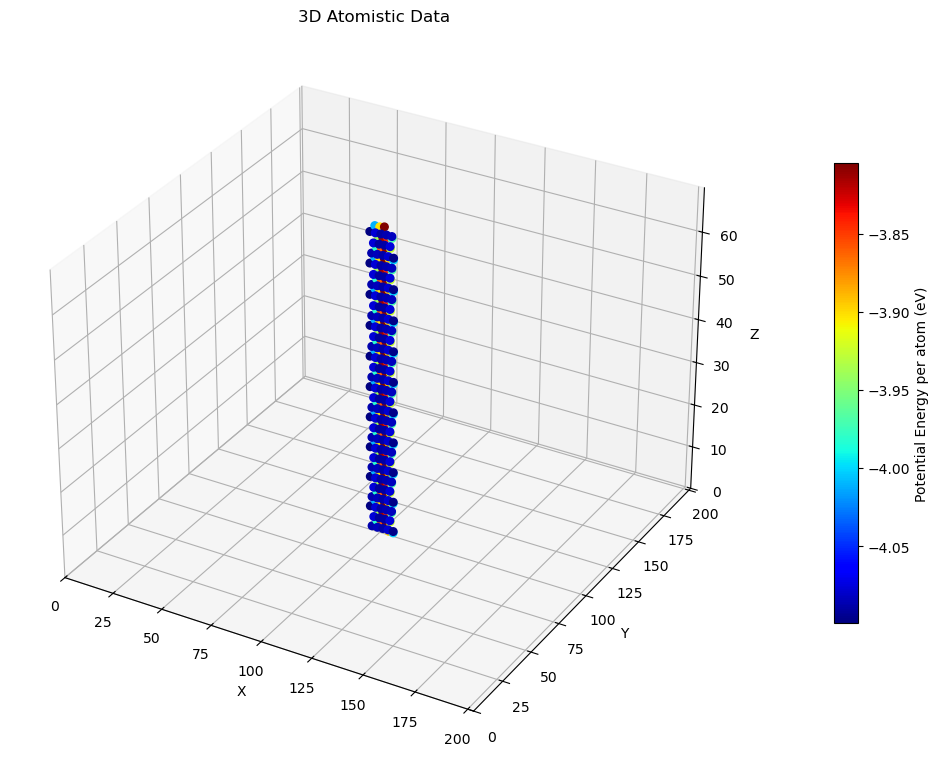

In [117]:
def filter_atoms(atom_df, box, radius, c_csym_thresh=1):
    """
    Filters atoms based on their centrosymmetry parameter and distance from the box center in the XY plane.

    Parameters:
    -----------
    atom_df : pandas.DataFrame
        DataFrame containing atom data with columns including 'x', 'y', and 'c_csym'.
    box : dict
        Dictionary with simulation box boundaries. Must contain keys:
        - 'xlo', 'xhi', 'ylo', 'yhi'
    radius : float
        Radial distance from the center of the XY plane within which atoms are selected.
    c_csym_thresh : float, optional, default=1
        Threshold for the centrosymmetry parameter. Only atoms with 'c_csym' greater than
        this value will be included.

    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame containing atoms that:
        - Lie within the specified radius of the box center in the XY plane.
        - Have a centrosymmetry parameter ('c_csym') greater than the specified threshold.

    Notes:
    ------
    - The XY center of the simulation box is computed as the midpoint of xlo/xhi and ylo/yhi.
    - Euclidean distance in the XY plane is used to filter atoms spatially.
    - This function is typically used to extract atoms in a dislocation core or defect region
      where atoms are highly distorted (i.e., have high 'c_csym').
    """
    # Calculate center coordinates of the simulation box in XY plane
    x_center = (box['xlo'] + box['xhi']) / 2
    y_center = (box['ylo'] + box['yhi']) / 2

    # Compute XY-plane distance of each atom from the box center
    dx = atom_df['x'] - x_center
    dy = atom_df['y'] - y_center
    r_xy_cond = np.sqrt(dx**2 + dy**2)

    # Compute the atoms that satisfy the centrosymmetry condition
    csym_cond = atom_df['c_csym'] > c_csym_thresh

    # Apply filters: 'c_peratom' above threshold AND distance within radius
    filtered_df = atom_df[(csym_cond) & (r_xy_cond < radius)]

    return filtered_df

dislocation_df = filter_atoms(atom_df, box, radius=20, c_csym_thresh=2)
print(f"\nNumber of atoms in the dislocaiton core: {len(dislocation_df)}\n")

plot_atomistic_data_3d(dislocation_df, box, s=30, alpha=1)

Dislocations are line defects in crystals that create local stress fields in the material. These stress fields are asymmetric and vary across the dislocation line, with one side typically under tensile stress and the other under compressive stress. This asymmetry is a direct consequence of the atomic mismatch introduced by the dislocation's Burgers vector and slip geometry.

To better analyze the behavior and structure of the dislocation core, it is often useful to split the dislocation into two parts:
- Tensile side: where atoms experience negative stress in the direction of interest (e.g., c_stress[1] < 0)
- Compressive side: where atoms are under positive stress (c_stress[1] > 0)

By separating these regions, we can:
- Study structural differences across the slip plane
- Quantify the distribution of stress or other per-atom properties
- Selectively modify or visualize different sides of the dislocation (e.g., for jog insertion or defect analysis)

The function split_dislocation() performs this division based on the sign of the stress component c_stress[1], which typically corresponds to the direction normal to the dislocation slip plane in edge dislocations.

In [ ]:
def split_dislocation(dislocation_df):
    """
    Splits a DataFrame of dislocation atoms into tensile and compressive sides based on
    the sign of the stress component 'c_stress[1]'.

    Parameters:
    -----------
    dislocation_df : pandas.DataFrame
        A DataFrame containing atomic data for dislocation core atoms.
        Must include the column 'c_stress[1]', representing a component of the atomic stress tensor.

    Returns:
    --------
    tuple of pandas.DataFrame
        - tensile_side: DataFrame containing atoms where 'c_stress[1]' < 0 (tensile side).
        - compressive_side: DataFrame containing atoms where 'c_stress[1]' > 0 (compressive side).

    Notes:
    ------
    - Atoms with zero stress in 'c_stress[1]' are excluded from both sides.
    - The function assumes that the dislocation core exhibits a stress contrast
      across its slip plane, which allows it to be split in this way.
    - Useful for analyzing or manipulating dislocation segments based on their
      local stress environment.

    Raises:
    -------
    KeyError
        If 'c_stress[1]' is not present in the input DataFrame.
    """

    tensile_side = dislocation_df[dislocation_df['c_stress[1]'] < 0]
    comrpessive_side = dislocation_df[dislocation_df['c_stress[1]'] > 0]

    return tensile_side, comrpessive_side

ten_dislo_df, comp_dislo_df = split_dislocation(dislocation_df)

In order to get a better picture, we can just make a 2D scatter plot of the data, which is what we've done below.

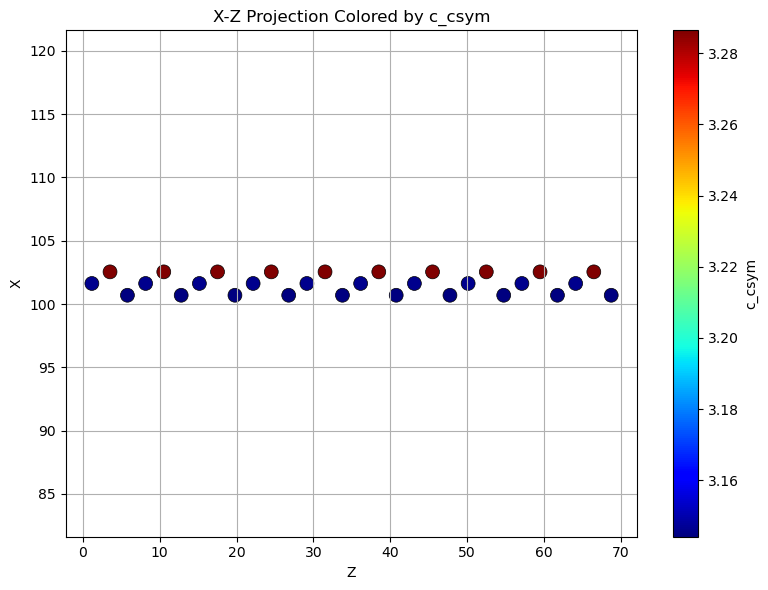

In [113]:
def plot_xz_colored_by_csym(atom_df, cmap='jet', s=100, alpha=1, buffer=20, csym_thresh=None):
    """
    Plots a 2D scatter plot with Z on X-axis and X on Y-axis, colored by c_csym,
    and optionally filters atoms based on a centrosymmetry threshold.

    Parameters:
    -----------
    atom_df : pd.DataFrame
        Must contain 'x', 'z', 'c_peratom', and 'c_csym' columns.

    cmap : str, optional
        Colormap for c_csym. Default is 'jet'.

    s : float, optional
        Size of scatter points. Default is 100.

    alpha : float, optional
        Transparency of points. Default is 1.

    buffer : float or None, optional
        If provided, limits Y-axis (i.e., X-position of atoms) to [mean-buffer, mean+buffer].
        If None, Y-axis limits are determined automatically.

    csym_thresh : float or None, optional
        If provided, only atoms with 'c_csym' less than this value will be plotted.

    Raises:
    -------
    ValueError
        If required columns are missing in atom_df.
    """
    required_cols = ['x', 'z', 'c_peratom', 'c_csym']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"atom_df must contain the following columns: {required_cols}")

    # Apply c_csym threshold filter if specified
    if csym_thresh is not None:
        atom_df = atom_df[atom_df['c_csym'] < csym_thresh]

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        atom_df['z'], atom_df['x'],
        c=atom_df['c_csym'],
        cmap=cmap,
        s=s,
        alpha=alpha,
        edgecolors='black',
        linewidth=0.5
    )

    plt.xlabel('Z')
    plt.ylabel('X')
    plt.title('X-Z Projection Colored by c_csym')
    cbar = plt.colorbar(sc)
    cbar.set_label('c_csym')

    if buffer is not None:
        y_mid = atom_df['x'].mean()
        plt.ylim([y_mid - buffer, y_mid + buffer])

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xz_colored_by_csym(comp_dislo_df, csym_thresh=3.5)

## Step 4: Writing out the IDs of dislocation core atoms

Now that that's all over, we can finally isolate the ID's of atoms that are inside of the dislocation core. That is what the get_high_energy_atom_ids() function does. It takes our dataframe of dislocation core atoms and outputs their ID's into a textfile.

In this function, you'll notice that we are calculating the distance of each atom from the center point of the simulation box (along the Z-axis), because it will allow us to sort the atom ID's based on their distance from the center of the simulation box. This is important, because when we later begin deleting core atoms from the dislocation to produce jogs, we want to form the jogs in the middle of the dislocation.

In [ ]:
def get_atom_ids_by_z_distance(atom_df, box, c_csym_thresh=None):
    """
    Extracts atom IDs sorted by their absolute Z-distance from the center of the simulation box,
    optionally filtered by a centrosymmetry parameter threshold, and saves them to a text file.

    Parameters:
    -----------
    atom_df : pandas.DataFrame
        DataFrame containing atom data. Must include columns:
        - 'id' : Unique identifier for each atom.
        - 'z' : Z-coordinate of each atom.
        - 'c_csym' : Centrosymmetry parameter of each atom.

    box : dict
        Dictionary specifying simulation box boundaries with keys:
        - 'zlo' : Lower bound of the box along the Z-axis.
        - 'zhi' : Upper bound of the box along the Z-axis.

    c_csym_thresh : float or None, optional (default=None)
        If provided, only atoms with 'c_csym' less than this threshold are included.
        If None, no filtering is done.

    output_file : str, optional (default='atom_ids_sorted_by_z.txt')
        Path to the output text file where sorted atom IDs will be saved.

    Returns:
    --------
    list
        List of atom IDs sorted by absolute distance from the box center along the Z-axis,
        optionally filtered by the centrosymmetry threshold.

    Raises:
    -------
    ValueError
        If required columns ('id', 'z', 'c_csym') are missing from atom_df.

    Notes:
    ------
    - The center of the box along Z is computed as the average of 'zlo' and 'zhi'.
    - Atoms are sorted by the absolute distance of their Z-coordinate from the box center.
    - Output file will contain one atom ID per line.
    """
    required_cols = {'id', 'z', 'c_csym'}
    if not required_cols.issubset(atom_df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_cols}")

    z_center = (box['zlo'] + box['zhi']) / 2

    # Optionally filter atoms by centrosymmetry parameter threshold
    if c_csym_thresh is not None:
        filtered_atoms = atom_df[atom_df['c_csym'] < c_csym_thresh].copy()
    else:
        filtered_atoms = atom_df.copy()

    # Calculate absolute distance from center along Z-axis
    filtered_atoms['z_dist'] = (filtered_atoms['z'] - z_center).abs()

    # Sort atoms by distance from center along Z
    sorted_atoms = filtered_atoms.sort_values(by='z_dist')

    sorted_ids = sorted_atoms['id'].tolist()

    # Save sorted IDs to file
    with open('selected_ids.txt', 'w') as f:
        for atom_id in sorted_ids:
            f.write(f"{atom_id}\n")

    print(f'{len(sorted_ids)} atoms selected as dislocation core')

get_atom_ids_by_z_distance(dislocation_df, box, c_csym_thresh=3.5)

[94350.0,
 94348.0,
 75478.0,
 94351.0,
 94050.0,
 75776.0,
 94645.0,
 112919.0,
 75482.0,
 94347.0,
 75479.0,
 113219.0,
 75481.0,
 113217.0,
 56609.0,
 113220.0,
 75181.0,
 56907.0,
 113514.0,
 131788.0,
 56613.0,
 113216.0,
 56610.0,
 132088.0,
 56612.0,
 132086.0,
 37740.0,
 132089.0,
 56312.0,
 38038.0,
 132383.0,
 150657.0,
 37744.0,
 132085.0,
 37741.0,
 150957.0,
 37743.0,
 150955.0,
 18871.0,
 150958.0,
 37443.0,
 19169.0,
 151252.0,
 169526.0,
 18875.0,
 150954.0,
 18872.0,
 169826.0,
 18874.0,
 169824.0,
 2.0,
 169827.0,
 18574.0,
 300.0,
 170121.0,
 188395.0,
 6.0,
 169823.0,
 3.0,
 5.0]